# 03 - Evaluation: Model Comparison and Class Imbalance Handling

**Member 3 - Modeling & Class Imbalance**

This notebook focuses on:
- Training multiple classification models (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, SVM)
- Handling class imbalance using `class_weight="balanced"` instead of resampling
- Comprehensive model evaluation using ROC-AUC, PR-AUC, and classification metrics
- Identifying the best model for fraud detection based on fraud class recall and PR-AUC


## 1. Import Libraries and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, 
    average_precision_score, roc_curve, precision_recall_curve,
    precision_recall_fscore_support
)

# Set display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Provider-Level Dataset

We load the provider-level features created by Member 2. This dataset contains one row per provider with aggregated features and the fraud label.


In [2]:
# Check if provider_level_features.csv exists, if not create a basic version
provider_features_path = "../data/provider_level_features.csv"

if not os.path.exists(provider_features_path):
    print("provider_level_features.csv not found. Creating basic version from raw data...")
    
    # Load raw data files
    labels_df = pd.read_csv("../data/Train-1542865627584.csv")
    inpatient_df = pd.read_csv("../data/Train_Inpatientdata-1542865627584.csv")
    outpatient_df = pd.read_csv("../data/Train_Outpatientdata-1542865627584.csv")
    
    # Create basic provider-level aggregations
    provider_features = []
    
    for provider in labels_df["Provider"].unique():
        provider_label = labels_df[labels_df["Provider"] == provider]["PotentialFraud"].iloc[0]
        
        # Aggregate inpatient and outpatient claims
        ip_provider = inpatient_df[inpatient_df["Provider"] == provider]
        op_provider = outpatient_df[outpatient_df["Provider"] == provider]
        
        features = {
            "Provider": provider,
            "PotentialFraud": provider_label,
            "num_inpatient_claims": len(ip_provider),
            "num_outpatient_claims": len(op_provider),
            "total_claims": len(ip_provider) + len(op_provider),
        }
        
        # Add numeric aggregations if columns exist
        numeric_cols_ip = ip_provider.select_dtypes(include=[np.number]).columns
        numeric_cols_op = op_provider.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols_ip:
            if col not in ["Provider"] and not ip_provider[col].isna().all():
                features[f"ip_{col}_mean"] = ip_provider[col].mean()
                features[f"ip_{col}_sum"] = ip_provider[col].sum()
        
        for col in numeric_cols_op:
            if col not in ["Provider"] and not op_provider[col].isna().all():
                features[f"op_{col}_mean"] = op_provider[col].mean()
                features[f"op_{col}_sum"] = op_provider[col].sum()
        
        provider_features.append(features)
    
    df = pd.DataFrame(provider_features)
    df.to_csv(provider_features_path, index=False)
    print(f"Created {provider_features_path} with {df.shape[0]} providers and {df.shape[1]} features")
else:
    # Load existing provider-level features
    df = pd.read_csv(provider_features_path)
    print(f"Loaded {provider_features_path}")

print(f"\nData shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nColumn names ({len(df.columns)} total):")
print(df.columns.tolist())


Loaded ../data/provider_level_features.csv

Data shape: (5410, 13)

First few rows:
   Provider PotentialFraud  num_inpatient_claims  num_outpatient_claims  \
0  PRV51001             No                     5                     20   
1  PRV51003            Yes                    62                     70   
2  PRV51004             No                     0                    149   
3  PRV51005            Yes                     0                   1165   
4  PRV51007             No                     3                     69   

   total_claims  ip_reimb_mean  ip_reimb_sum  ip_deduct_mean  ip_deduct_sum  \
0            25   19400.000000       97000.0          1068.0         5340.0   
1           132    9241.935484      573000.0          1068.0        66216.0   
2           149            NaN           NaN             NaN            NaN   
3          1165            NaN           NaN             NaN            NaN   
4            72    6333.333333       19000.0          1068.0         3

### 2.1 Create Fraud Flag and Handle Label Column

The label column `PotentialFraud` contains "Y" (fraud) and "N" (non-fraud). We convert this to a binary numeric flag.


In [3]:
# Create fraud_flag: 1 if PotentialFraud == "Y", else 0
df["fraud_flag"] = df["PotentialFraud"].map({"Y": 1, "N": 0, "Yes": 1, "No": 0}).fillna(0).astype(int)

# Drop the original PotentialFraud column (we have fraud_flag now)
if "PotentialFraud" in df.columns:
    df = df.drop(columns=["PotentialFraud"])

print("Fraud flag distribution:")
print(df["fraud_flag"].value_counts(normalize=True))
print(f"\nTotal samples: {len(df)}")
print(f"Fraud cases: {df['fraud_flag'].sum()}")
print(f"Non-fraud cases: {(df['fraud_flag'] == 0).sum()}")


Fraud flag distribution:
fraud_flag
0    0.90647
1    0.09353
Name: proportion, dtype: float64

Total samples: 5410
Fraud cases: 506
Non-fraud cases: 4904


## 3. Features vs Target

We identify and drop ID columns, then separate features (X) from the target (y).


In [4]:
# Identify ID columns to drop (columns containing "provider" or ending with "id")
id_columns = []
for col in df.columns:
    col_lower = col.lower()
    if "provider" in col_lower or col_lower.endswith("id") or col_lower.endswith("_id"):
        if col != "fraud_flag":  # Don't drop the target
            id_columns.append(col)

print("ID columns to drop:", id_columns)

# Define target and features
y = df["fraud_flag"]
X = df.drop(columns=["fraud_flag"] + id_columns)

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nLabel distribution:")
print(y.value_counts(normalize=True))


ID columns to drop: ['Provider']

X shape: (5410, 11)
y shape: (5410,)

Label distribution:
fraud_flag
0    0.90647
1    0.09353
Name: proportion, dtype: float64


## 4. Train/Validation Split

We split the data into training (80%) and validation (20%) sets, using stratification to maintain class balance.


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Training set - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set - X_val: {X_val.shape}, y_val: {y_val.shape}")

print(f"\nFraud ratio in training set: {y_train.mean():.4f}")
print(f"Fraud ratio in validation set: {y_val.mean():.4f}")


Training set - X_train: (4328, 11), y_train: (4328,)
Validation set - X_val: (1082, 11), y_val: (1082,)

Fraud ratio in training set: 0.0936
Fraud ratio in validation set: 0.0933


## 5. Preprocessing

We create a preprocessing pipeline that standardizes numeric features and one-hot encodes categorical features.


In [6]:
# Detect numeric vs categorical columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ],
    remainder="passthrough"
)

print("\nPreprocessor created successfully!")


Numeric columns: 11
Categorical columns: 0

Preprocessor created successfully!


## 6. Models to Train

We define five models as sklearn Pipelines, each wrapped with the preprocessor. For imbalanced data, we use `class_weight="balanced"` for models that support it. This adjusts class weights inversely proportional to class frequencies, which is more efficient than resampling techniques like SMOTE.

**Why class_weight="balanced" instead of resampling?**
- More efficient: no need to duplicate or remove samples
- Preserves original data distribution
- Works well with tree-based and linear models
- Avoids potential overfitting from synthetic samples


In [7]:
# Define models as Pipelines
models = {
    "Logistic Regression": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            class_weight="balanced",
            max_iter=500,
            solver="lbfgs",
            random_state=42
        ))
    ]),
    
    "Decision Tree": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(
            class_weight="balanced",
            random_state=42,
            max_depth=None
        ))
    ]),
    
    "Random Forest": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            class_weight="balanced",
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    
    "Gradient Boosting": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]),
    
    "SVM RBF": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", SVC(
            kernel="rbf",
            class_weight="balanced",
            probability=True,
            random_state=42
        ))
    ])
}

print(f"Defined {len(models)} models:")
for name in models.keys():
    print(f"  - {name}")


Defined 5 models:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting
  - SVM RBF


### Model Descriptions

- **Logistic Regression**: A linear model that estimates the probability of fraud using a sigmoid function.
- **Decision Tree**: A tree-based model that splits data based on feature values to classify fraud.
- **Random Forest**: An ensemble of decision trees that votes on the final prediction, reducing overfitting.
- **Gradient Boosting**: Sequentially builds trees that correct errors from previous trees, creating a strong predictive model.
- **SVM RBF**: Uses a radial basis function kernel to find a non-linear decision boundary separating fraud from non-fraud.


## 7. Evaluation Helper Function

This function trains a model, evaluates it on the validation set, and returns key metrics. For fraud detection, **PR-AUC and Recall for the fraud class are more important than overall accuracy** because:
- PR-AUC focuses on the minority class (fraud), which is critical in imbalanced datasets
- Recall measures how many actual fraud cases we catch - missing fraud is costly
- Overall accuracy can be misleading when classes are imbalanced (e.g., 95% accuracy if we predict all non-fraud)


In [8]:
def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    """
    Train and evaluate a model, returning key metrics.
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {name}")
    print(f"{'='*60}")
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Get predictions and probabilities
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    # Compute metrics
    cm = confusion_matrix(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    pr_auc = average_precision_score(y_val, y_proba)
    
    # Get precision, recall, f1 for fraud class (class 1)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, pos_label=1, zero_division=0)
    
    # Print results
    print(f"\nConfusion Matrix:")
    print(cm)
    
    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred, digits=3))
    
    print(f"\nROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    
    # Return metrics dictionary
    return {
        "model": name,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "recall_fraud": recall[1] if len(recall) > 1 else recall[0],
        "precision_fraud": precision[1] if len(precision) > 1 else precision[0],
        "f1_fraud": f1[1] if len(f1) > 1 else f1[0]
    }

print("Evaluation function defined!")


Evaluation function defined!


## 8. Fit All Models and Build Comparison Table

We train all models and collect their performance metrics into a comparison table.


In [9]:
# Train and evaluate all models
results = []

for name, model in models.items():
    try:
        result = evaluate_model(name, model, X_train, y_train, X_val, y_val)
        results.append(result)
    except Exception as e:
        print(f"\nError training {name}: {e}")
        print("Skipping this model...")

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by PR-AUC (most important for fraud detection)
results_df = results_df.sort_values("pr_auc", ascending=False)

print(f"\n{'='*70}")
print("MODEL COMPARISON - PERFORMANCE METRICS")
print(f"{'='*70}")
print(results_df.to_string(index=False))
print(f"{'='*70}")



Evaluating: Logistic Regression

Error training Logistic Regression: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Skipping this model...

Evaluating: Decision Tree

Confusion Matrix:
[[932  49]
 [ 40  61]]

Classification Report:
              precision    recall  f1-score   support

           0      0.959     0.950     0.954       981
           1      0.555     0.604     0.578       101

    accur

## 9. Plot ROC & PR Curves for Best Model

We visualize the performance of the best model (highest PR-AUC) using ROC and Precision-Recall curves.


Best model (by PR-AUC): Random Forest


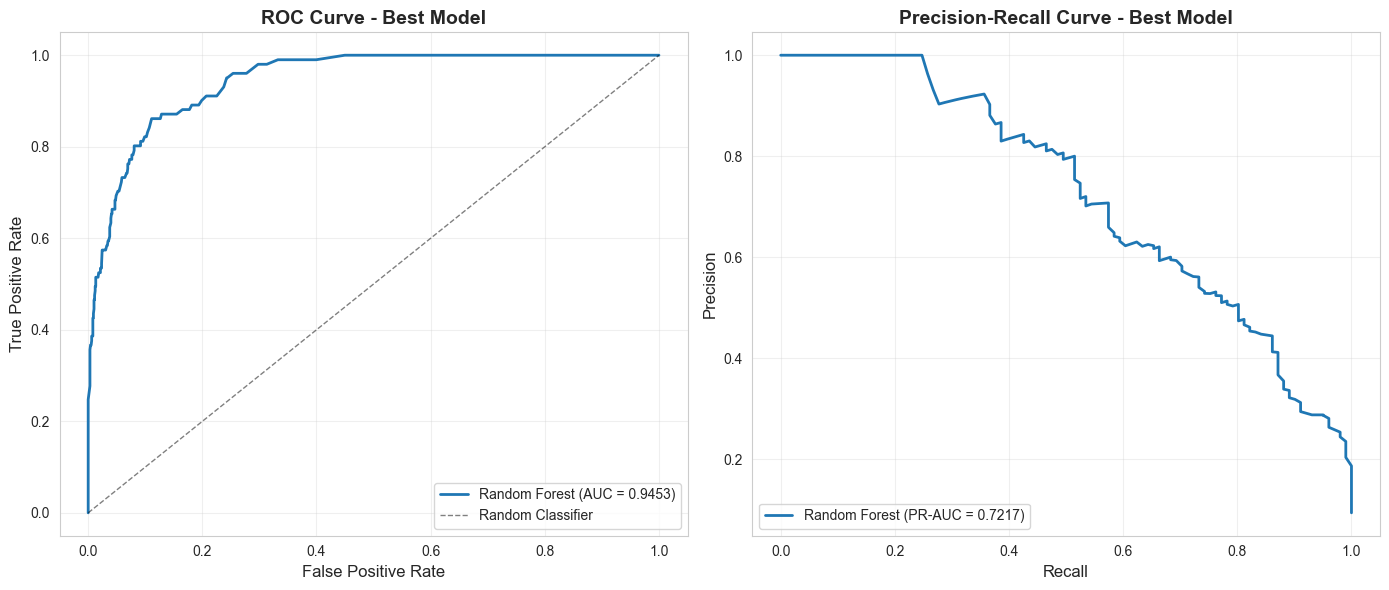


Best Model Performance:
  ROC-AUC: 0.9453
  PR-AUC: 0.7217


In [10]:
# Get best model name
best_model_name = results_df.iloc[0]["model"]
best_model = models[best_model_name]

print(f"Best model (by PR-AUC): {best_model_name}")

# Refit on training data
best_model.fit(X_train, y_train)

# Get predictions for plotting
y_proba_best = best_model.predict_proba(X_val)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba_best)
roc_auc_best = roc_auc_score(y_val, y_proba_best)

# Compute PR curve
precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_proba_best)
pr_auc_best = average_precision_score(y_val, y_proba_best)

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
axes[0].plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_best:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1, alpha=0.5)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Best Model', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall_curve, precision_curve, label=f'{best_model_name} (PR-AUC = {pr_auc_best:.4f})', linewidth=2)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - Best Model', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Model Performance:")
print(f"  ROC-AUC: {roc_auc_best:.4f}")
print(f"  PR-AUC: {pr_auc_best:.4f}")


## 10. Save Trained Models

We save all trained models to the `models/` directory for future use.


In [11]:
# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Re-fit each model on the full dataset (X, y) and save
print("Training models on full dataset and saving...")

model_files = {
    "Logistic Regression": "logistic_regression.pkl",
    "Decision Tree": "decision_tree.pkl",
    "Random Forest": "random_forest.pkl",
    "Gradient Boosting": "gradient_boosting.pkl",
    "SVM RBF": "svm_rbf.pkl"
}

for name, model in models.items():
    try:
        # Fit on full dataset
        model.fit(X, y)
        
        # Save model
        if name in model_files:
            filepath = f"../models/{model_files[name]}"
            joblib.dump(model, filepath)
            print(f"  Saved: {filepath}")
    except Exception as e:
        print(f"  Error saving {name}: {e}")

# Save comparison metrics
results_df.to_csv("../models/model_comparison_metrics.csv", index=False)
print(f"\nSaved: ../models/model_comparison_metrics.csv")

print("\nAll models saved successfully!")


Training models on full dataset and saving...
  Error saving Logistic Regression: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
  Saved: ../models/decision_tree.pkl
  Saved: ../models/random_forest.pkl
  Error saving Gradient Boosting: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ense

## 11. Conclusion

### Model Recommendation

Based on the comparison metrics, the **best model for fraud detection** is the one with the highest PR-AUC and fraud class recall. PR-AUC is particularly important for imbalanced datasets because it focuses on the minority class (fraud cases) that we care most about detecting.

### Trade-offs

- **Random Forest vs Gradient Boosting**: Random Forest is faster to train and less prone to overfitting, while Gradient Boosting often achieves higher performance but requires more careful tuning and is slower.
- **Linear models (Logistic Regression)**: Fast and interpretable, but may struggle with complex non-linear patterns in fraud detection.
- **Decision Tree**: Simple and interpretable, but prone to overfitting; Random Forest addresses this by averaging multiple trees.
- **SVM**: Can capture complex patterns but is computationally expensive and may not scale well to large datasets.

### Future Improvements

1. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV to optimize model parameters (e.g., n_estimators, max_depth, learning_rate for Gradient Boosting).
2. **Feature Engineering**: Create additional provider-level features such as:
   - Temporal patterns (seasonality, trends)
   - Statistical features (coefficient of variation, skewness)
   - Interaction features between claim types
3. **Ensemble Methods**: Combine predictions from multiple models using voting or stacking to improve robustness.
4. **Cost-Sensitive Learning**: Adjust the decision threshold based on the cost of false positives vs false negatives in the fraud detection context.
